In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import nltk
import torch 
import torch.nn as nn
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from utils import eval_model, train_model, augment_data_multiclass

/Users/farrelsalim/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/farrelsalim/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

In [3]:
train_df = pd.read_json('../train.jsonl', lines=True)
X_train = train_df['string']
y_train = train_df['label']

dev_df = pd.read_json('../dev.jsonl', lines=True)
X_dev = dev_df['string']
y_dev = dev_df['label']

test_df = pd.read_json('../test.jsonl', lines=True)
X_test = test_df['string']
y_test = test_df['label']

train_df

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
0,explicit,175.0,Introduction,168.0,"However, how frataxin interacts with the Fe-S ...",background,1.0000,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,True,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,11,NaN,NaN
1,explicit,36.0,Novel Quantitative Trait Loci for Seminal Root...,16.0,"In the study by Hickey et al. (2012), spikes w...",background,1.0000,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,True,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,2,NaN,NaN
2,explicit,228.0,Introduction,225.0,"The drug also reduces catecholamine secretion,...",background,1.0000,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,False,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,0,NaN,NaN
3,explicit,110.0,Discussion,46.0,By clustering with lowly aggressive close kin ...,background,1.0000,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,3,NaN,NaN
4,explicit,239.0,Discussion,234.0,Ophthalmic symptoms are rare manifestations of...,background,1.0000,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,False,88b86556857f4374842d2af2e359576806239175>a5bb0...,88b86556857f4374842d2af2e359576806239175>a5bb0...,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8238,explicit,50.0,,28.0,"Importantly, the results of Pascalis et al. (2...",background,0.7350,6f68ccd37718366c40ae6aeedf0b935bf560b215,60ed4bdabf92b2fbd6162dbd8979888cccca55d7,True,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,15,NaN,NaN
8239,explicit,182.0,DISCUSSION,179.0,"As suggested by Nguena et al, there is a need ...",background,0.7508,f2a1c1704f9587c94ed95bc98179dc499e933f5e,574e659da7f6c62c07bfaaacd1f31d65bd75524c,True,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,1,NaN,NaN
8240,explicit,120.0,DISCUSSION,108.0,Skeletal muscle is also a primary site of dise...,background,1.0000,18c97ea2ff60c110cc2a523e0fdf729608cbb083,fc13b9c3dfcc121013edaa12fa8ce7842aaed21a,False,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,8,NaN,NaN
8241,explicit,221.0,,185.0,ACTIVATION OF TRANSCRIPTION FACTORS Roles for ...,method,NaN,4ec9b89857c0b27e8a4bd3745b7358f387773527,81affdba19e38e2b17cf7b9e93792cc2028cf21d,True,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,0,NaN,NaN


<Axes: >

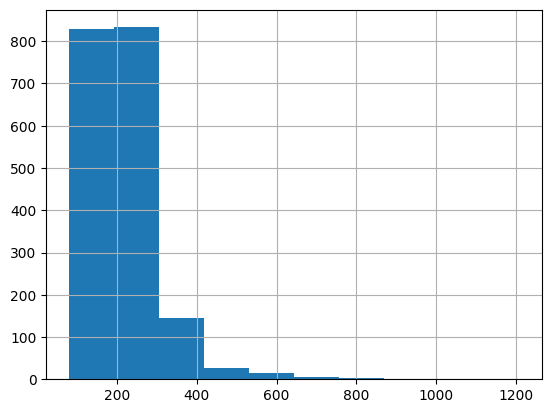

In [4]:
X_test.apply(lambda x: len(x)).hist()

In [5]:
X_train, y_train = augment_data_multiclass(X_train, y_train)

In [6]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform string column
y_train = label_encoder.fit_transform(y_train)
y_dev = label_encoder.transform(y_dev)
y_test = label_encoder.transform(y_test)

print(y_train)

[0 0 0 ... 2 2 2]


## Model Creation

In [7]:
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
for name, param in model.named_parameters():
    print(name)

transformer.wte.weight
transformer.wpe.weight
transformer.h.0.ln_1.weight
transformer.h.0.ln_1.bias
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_attn.bias
transformer.h.0.attn.c_proj.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.ln_2.weight
transformer.h.0.ln_2.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.1.ln_1.weight
transformer.h.1.ln_1.bias
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_attn.bias
transformer.h.1.attn.c_proj.weight
transformer.h.1.attn.c_proj.bias
transformer.h.1.ln_2.weight
transformer.h.1.ln_2.bias
transformer.h.1.mlp.c_fc.weight
transformer.h.1.mlp.c_fc.bias
transformer.h.1.mlp.c_proj.weight
transformer.h.1.mlp.c_proj.bias
transformer.h.2.ln_1.weight
transformer.h.2.ln_1.bias
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_attn.bias
transformer.h.2.attn.c_proj.weight
transformer.h.2.attn.c_proj.bias
transformer.h.2.ln_2

In [9]:
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

## Model training

In [10]:
# model = train_model(model, tokenizer, 5, 4e-5, 16, X_train, y_train)
# WARNING: This will take very long

## First trained model 

This is GPT2 model with all parameters trained. Will take ~30 mins to train in SOC cluster.

We use:
- learning_rate = 4e-5
- num_epoch = 1
- batch_size = 16
- tokenizer = default GPT2Tokenizer
- Only data augmentation for preprocessing

This can be trained by running `train_model(model, tokenizer, num_epoch=1, learning_rate=4e-5, batch_size=16, X_train, y_train, use_preprocess=False)`

In [11]:
# Load previously trained model
# Unfortunately, can't push it to github as it exceeds the 100 MB limit
# Ask the model from me if needed :)
model.load_state_dict(torch.load('gpt2-1.pth'))

# Alternatively, can do the following:
# model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=3)
# model.config.pad_token_id = model.config.eos_token_id
# model = train_model(model, tokenizer, num_epoch=1, learning_rate=4e-5, batch_size=16, X_train, y_train, use_preprocess=False)

<All keys matched successfully>

In [12]:
# Find evaluation in test data, we can get:
# f1 = 0.8506542868172478 and accuracy = 0.8602901665771091
# WARNING: this will take quite long without GPU
eval_model(model, tokenizer, X_test, y_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(0.8506542868172478, 0.8602901665771091)

## Second trained model 

This is GPT2 model with all parameters trained. Will take ~6 hours to train in SOC cluster.

We use:
- learning_rate = 4e-5
- num_epoch = 10
- batch_size = 16
- tokenizer = default GPT2Tokenizer
- Only data augmentation for preprocessing

This can be trained by running `train_model(model, tokenizer, num_epoch=10, learning_rate=4e-5, batch_size=16, X_train, y_train, use_preprocess=False)`

In [13]:
# Load previously trained model
# Unfortunately, can't push it to github as it exceeds the 100 MB limit
# Ask the model from me if needed :)
model.load_state_dict(torch.load('gpt2-2.pth'))

# Alternatively, can do the following:
# model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=3)
# model.config.pad_token_id = model.config.eos_token_id
# model = train_model(model, tokenizer, num_epoch=10, learning_rate=4e-5, batch_size=16, X_train, y_train, use_preprocess=False)

<All keys matched successfully>

In [ ]:
# Find evaluation in test data, we can get:
# f1 = 0.8382855666754353 and 0.8538420204191295
# WARNING: this will take quite long without GPU
eval_model(model, tokenizer, X_test, y_test)

## Third trained model 

This is GPT2 model with all parameters trained. Will take ~30 mins to train in SOC cluster.

We use:
- learning_rate = 2e-5
- num_epoch = 1
- batch_size = 16
- tokenizer = default GPT2Tokenizer
- Only data augmentation for preprocessing

This can be trained by running `train_model(model, tokenizer, num_epoch=1, learning_rate=2e-5, batch_size=16, X_train, y_train, use_preprocess=False)`

In [14]:
# Load previously trained model
# Unfortunately, can't push it to github as it exceeds the 100 MB limit
# Ask the model from me if needed :)
model.load_state_dict(torch.load('gpt2-3.pth'))

# Alternatively, can do the following:
# model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=3)
# model.config.pad_token_id = model.config.eos_token_id
# model = train_model(model, tokenizer, num_epoch=1, learning_rate=2e-5, batch_size=16, X_train, y_train, use_preprocess=False)

<All keys matched successfully>

In [ ]:
# Find evaluation in test data, we can get:
# f1 = 0.8170804618955835 and accuracy = 0.8350349274583557
# WARNING: this will take quite long without GPU
eval_model(model, tokenizer, X_test, y_test)

## Fourth trained model 

This is GPT2 model with all parameters trained. Will take ~6 hours to train in SOC cluster.

We use:
- learning_rate = 2e-5
- num_epoch = 10
- batch_size = 16
- tokenizer = default GPT2Tokenizer
- Only data augmentation for preprocessing

This can be trained by running `train_model(model, tokenizer, num_epoch=1, learning_rate=2e-5, batch_size=16, X_train, y_train, use_preprocess=False)`

In [15]:
# Load previously trained model
# Unfortunately, can't push it to github as it exceeds the 100 MB limit
# Ask the model from me if needed :)
model.load_state_dict(torch.load('gpt2-4.pth'))

# Alternatively, can do the following:
# model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=3)
# model.config.pad_token_id = model.config.eos_token_id
# model = train_model(model, tokenizer, num_epoch=10, learning_rate=2e-5, batch_size=16, X_train, y_train, use_preprocess=False)

<All keys matched successfully>

In [16]:
# Find evaluation in test data, we can get:
# f1 = 0.8432042425451008 and accuracy 0.8592154755507792
# WARNING: this will take quite long without GPU
eval_model(model, tokenizer, X_test, y_test)

(0.8432042425451008, 0.8592154755507792)